# PIK3CA: Effects of Hotspot Mutation on HRAS

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

### Import CPTAC

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [4]:
protein = 'HRAS'
gene = 'PIK3CA'

## Extract the data for hotspot mutations only 

In [5]:
#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

In [6]:
p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
#print(p10_mutations)
p10_mutations['Within_Hotspot'] = False
p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)
print(len(p10_mutations.loc[(p10_mutations['Within_Hotspot'] == True)]))

19


## Hotspot mutation vs non-hotspot mutation

In [7]:
in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == False]
ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
print(ttest)

Ttest_indResult(statistic=-1.024460551496374, pvalue=0.3114823476147295)


## Hotspot mutation vs other mutations and wildtype

In [8]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] != True]
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.9781473222017022, pvalue=0.33068286815988157)


## All mutations vs wildtype

In [9]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] != 'Wildtype']
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.58796394809874, pvalue=0.5580623705425318)


## Hotspot mutation v wildtype

In [10]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.8824110274023458, pvalue=0.3809091657475291)


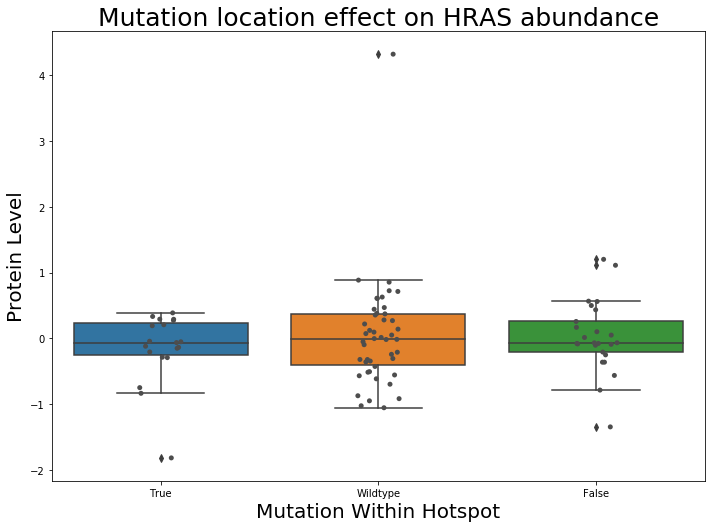

In [11]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on HRAS abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

# Phosphoproteomic Abundance

In [12]:
phos_mutations = CPTAC.compare_mutations(phos, 'RAS', gene)
phos_mutations['Within_Hotspot'] = False
phos_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True

phos_mutations.loc[phos_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
print(phos_mutations)


phos_mutations = phos_mutations.loc[phos_mutations['Patient_Type'] == 'Tumor']
#phos_mutations = phos_mutations.dropna(axis = 0)
#print(phos_mutations)
phos_sites = list(phos_mutations)
phos_sites = phos_sites[:(len(phos_sites) - 3)]

      GORASP1-S220  GORASP1-S241  GORASP1-S243  GORASP1-S248  GORASP1-T216  \
S001       0.53400      0.531000           NaN           NaN      0.865500   
S002       0.00000      0.702000           NaN           NaN      0.399000   
S003       0.37200      0.420000           NaN           NaN      0.482500   
S004           NaN     -0.991000           NaN           NaN     -0.173000   
S005      -0.06100      0.165950           NaN           NaN      0.187950   
S006       1.21000      0.259550           NaN           NaN      0.372500   
S007       0.23100      0.023400           NaN           NaN     -0.160500   
S008       0.48600      0.602000        0.0711           NaN      0.314200   
S009           NaN     -0.647000           NaN           NaN      0.098100   
S010       0.19100      0.163500           NaN           NaN      0.131200   
S011      -0.10900      0.015200           NaN         0.181      0.017050   
S012       0.14000      0.698500        0.1050           NaN    

## Hotspot mutation vs non-hotspot mutation

In [13]:
sites = phos.columns
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == False]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site) 
    #print("Test for " + site, ttest)
    
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)


/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['RASEF-S102']
[0.01001862]
{'RASEF-S102': 0.010018617304438412}


## Hotspot mutation vs other mutations and wildtype

In [14]:
sites = phos.columns
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] != True]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site) 
    #print("Test for " + site, ttest)
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


## All mutations vs wildtype

In [15]:
sites = phos.columns
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype']
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] != 'Wildtype']
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site) 
    #print("Test for " + site, ttest)
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


## Hotspot mutation v wildtype

In [16]:
sites = phos.columns
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype']
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    p_values.append(ttest[1])
    site_names.append(site) 
    #print("Test for " + site, ttest)
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


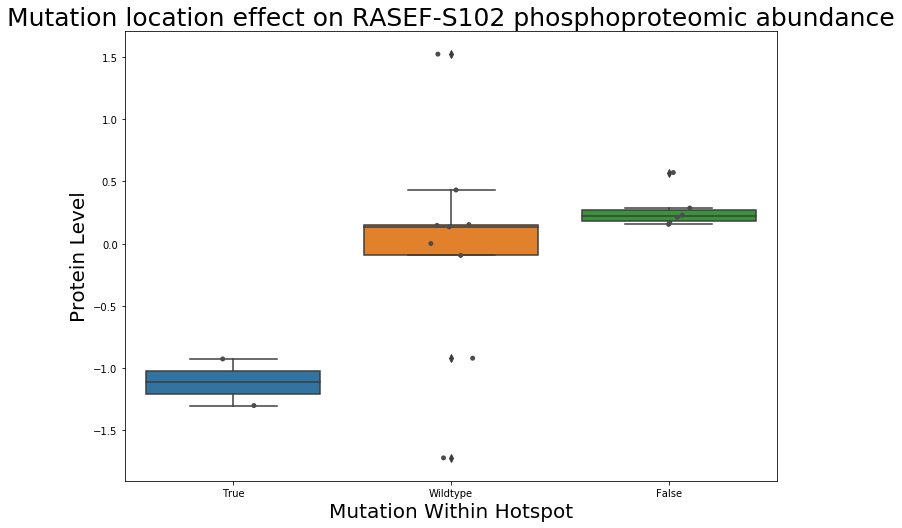

In [17]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'RASEF-S102', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'RASEF-S102', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on RASEF-S102 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

ValueError: Could not interpret input 'IRS2-S391'

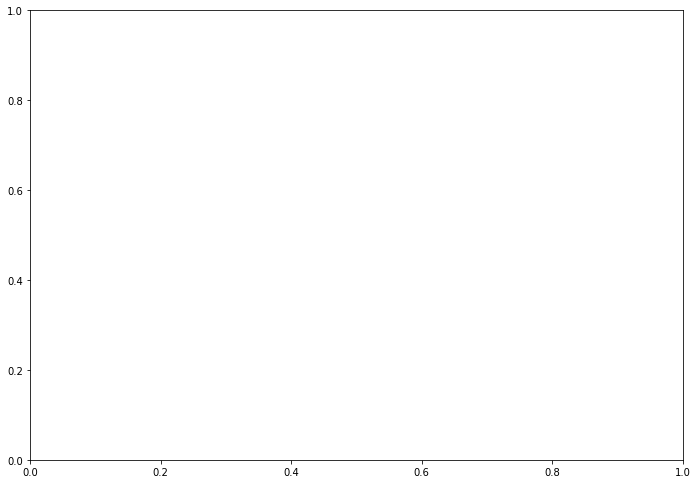

In [18]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS2-S391', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'IRS2-S391', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on IRS2 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()